In [26]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

In [2]:
import xgboost as xgb

In [3]:
data = pd.read_csv('/home/nikita/PycharmProjects/natural_language/data/test_prepocess.csv')
data.head()

,stars,text,useful,funny
0,3,The good: mini doughnuts and americano friendl...,1,0
1,3,I really like the décor of the place and the w...,0,0
2,5,"Great service, clean and great food, this plac...",1,0
3,5,This place has never failed on me! \nLate nigh...,0,0
4,2,This is a fast food spin off from Paramount Fi...,1,1


In [4]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_batch = train_data[0:10000]
test_batch = test_data[0:5000]

In [5]:
def build_sentences_vector(sentence):
    words = sentence.split()
    result = np.zeros(100)
    size = 0
    for word in words:
        if word in embeding_model.wv.vocab:
            result+=embeding_model.wv[word]
            size+=1
    if size == 0:
        size = 1
    result /= size
    return result

In [27]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy                     %s' % accuracy_score(target, predictions))
    print('explained_variance_score     %s' % explained_variance_score(target, predictions))
    print('mean_absolute_error          %s' % mean_absolute_error(target, predictions))
    print('mean_squared_error           %s' % mean_squared_error(target, predictions))
    print('mean_squared_log_error       %s' % mean_squared_log_error(target, predictions))
    print('r2_score                     %s' % r2_score(target, predictions))
    print()
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')
    
def plot_confusion_matrix(cm, title='Матрица ошибок', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    my_tags = pd.unique(train_batch.stars)
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('Исходные метки')
    plt.xlabel('Полученные метки')
    
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data.text)
    predictions = classifier.predict(data_features)
    target = data.stars
    evaluate_prediction(predictions, target)

In [7]:
embeding_model = Word2Vec.load('Yelp_embedings')
len(embeding_model.wv.vocab)

2018-05-10 12:17:12,196 : INFO : loading Word2Vec object from Yelp_embedings
2018-05-10 12:17:15,358 : INFO : loading wv recursively from Yelp_embedings.wv.* with mmap=None
2018-05-10 12:17:15,359 : INFO : setting ignored attribute vectors_norm to None
2018-05-10 12:17:15,360 : INFO : loading vocabulary recursively from Yelp_embedings.vocabulary.* with mmap=None
2018-05-10 12:17:15,361 : INFO : loading trainables recursively from Yelp_embedings.trainables.* with mmap=None
2018-05-10 12:17:15,362 : INFO : setting ignored attribute cum_table to None
2018-05-10 12:17:15,363 : INFO : loaded Yelp_embedings


101865

In [8]:
%%time
train_data_features = []
for sentense in train_batch.text:
    train_data_features.append(build_sentences_vector(sentense))
test_data_transform = []
for sentense in test_batch.text:
    test_data_transform.append(build_sentences_vector(sentense))

CPU times: user 5.86 s, sys: 33.5 ms, total: 5.89 s
Wall time: 6.09 s


In [13]:
tr_f = pd.DataFrame(train_data_features)
ts_f = pd.DataFrame(test_data_transform)

In [15]:
tr_f.shape[0]

10000

In [16]:
train_X = big_X[0:tr_f.shape[0]].as_matrix()
test_X = big_X[tr_f.shape[0]::].as_matrix()

In [22]:
%%time
# gbm = xgb.XGBClassifier(max_depth=48, n_estimators=345, learning_rate=0.05, booster='gbtree')
gbm = xgb.XGBClassifier(max_depth=10, n_estimators=50, learning_rate=0.05, booster='gbtree')

CPU times: user 29 µs, sys: 0 ns, total: 29 µs
Wall time: 33.9 µs


In [23]:
%%time
gbm.fit(train_X, train_batch.stars, verbose=True)

CPU times: user 53.7 s, sys: 28 ms, total: 53.7 s
Wall time: 53.8 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [24]:
%%time
predictions = gbm.predict(test_X)

CPU times: user 215 ms, sys: 5 µs, total: 215 ms
Wall time: 282 ms


/home/nikita/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy                     0.5744
explained_variance_score     0.3706673825693294
mean_absolute_error          0.6514
mean_squared_error           1.3386
mean_squared_log_error       0.09402941547431636
r2_score                     0.3466561720365484

confusion matrix
 [[ 445   65   46   42   96]
 [ 111   65   67   92   69]
 [  66   50  115  276  118]
 [  40   27   51  476  546]
 [  45   15   25  281 1771]]
(row=expected, col=predicted)


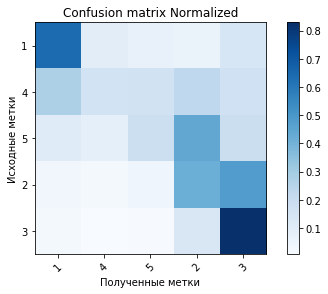

In [28]:
evaluate_prediction(predictions, test_batch.stars)